# Tests of velocities of haloes in CSiBORG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csiborgtools

from scipy.stats import spearmanr, binned_statistic

%matplotlib inline
%load_ext autoreload
%autoreload 2

## FoF vs SPH velocity

In [2]:
kind = "main"
nsnap = 99
nsim = 17417

field_reader = csiborgtools.read.CSiBORG2Field(nsim, kind)
catalogue = csiborgtools.read.CSiBORG2Catalogue(nsim, nsnap, kind)
boxsize = csiborgtools.simname2boxsize("csiborg2_main")

In [3]:
velocity_field = field_reader.velocity_field("SPH", 1024)

In [4]:
pos = catalogue["cartesian_pos"] / boxsize
vel = catalogue["cartesian_vel"]
mass = catalogue["totmass"]

spherical_pos = catalogue["spherical_pos"]
RA = np.deg2rad(spherical_pos[:, 1])
dec = np.deg2rad(spherical_pos[:, 2])

def project_radial(vx, vy, vz, RA, dec):
    return vx * np.cos(dec) * np.cos(RA) + vy * np.cos(dec) * np.sin(RA) + vz * np.sin(dec)

In [5]:
vx, vy, vz = csiborgtools.field.evaluate_cartesian_cic(velocity_field[0], velocity_field[1], velocity_field[2], pos=pos)

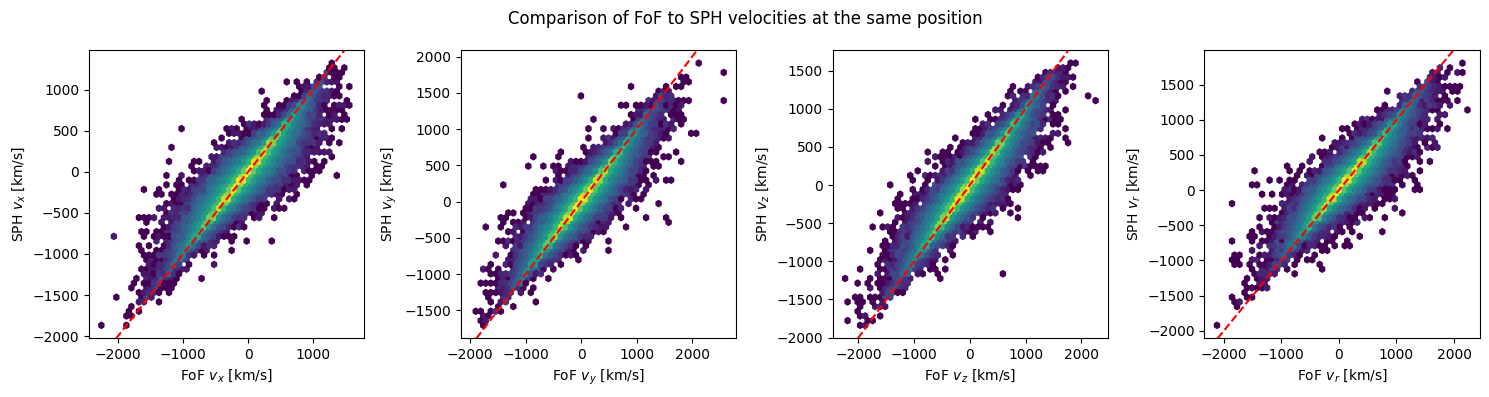

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
fig.suptitle("Comparison of FoF to SPH velocities at the same position")

axs[0].hexbin(vel[:, 0], vx, gridsize=50, bins="log", mincnt=1)
axs[0].set_xlabel(r"FoF $v_x ~ [\mathrm{km} / \mathrm{s}]$")
axs[0].set_ylabel(r"SPH $v_x ~ [\mathrm{km} / \mathrm{s}]$")

axs[1].hexbin(vel[:, 1], vy, gridsize=50, bins="log", mincnt=1)
axs[1].set_xlabel(r"FoF $v_y ~ [\mathrm{km} / \mathrm{s}]$")
axs[1].set_ylabel(r"SPH $v_y ~ [\mathrm{km} / \mathrm{s}]$")

axs[2].hexbin(vel[:, 2], vz, gridsize=50, bins="log", mincnt=1)
axs[2].set_xlabel(r"FoF $v_z ~ [\mathrm{km} / \mathrm{s}]$")
axs[2].set_ylabel(r"SPH $v_z ~ [\mathrm{km} / \mathrm{s}]$")


vr_fof = project_radial(vel[:, 0], vel[:, 1], vel[:, 2], RA, dec)
vr_sph = project_radial(vx, vy, vz, RA, dec)
axs[3].hexbin(vr_fof, vr_sph, gridsize=50, bins="log", mincnt=1)
axs[3].set_xlabel(r"FoF $v_r ~ [\mathrm{km} / \mathrm{s}]$")
axs[3].set_ylabel(r"SPH $v_r ~ [\mathrm{km} / \mathrm{s}]$")

for i in range(4):
    axs[i].axline([0, 0], [1, 1], color="red", ls="--")

fig.tight_layout()
fig.savefig("../plots/fof_to_sph_velocity_comparison.png")
fig.show()

## Correlation of the peculiar velocity and total mass

In [7]:
kind = "main"
nsnap = 99
nsim = 17417

### FoF haloes

In [8]:
catalogue = csiborgtools.read.CSiBORG2Catalogue(nsim, nsnap, kind)

vel = catalogue["cartesian_vel"]
mass = catalogue["totmass"]
velmag = np.linalg.norm(vel, axis=1)

spearmanr(mass, velmag)

SignificanceResult(statistic=-0.011239061725954754, pvalue=1.637324987020833e-17)

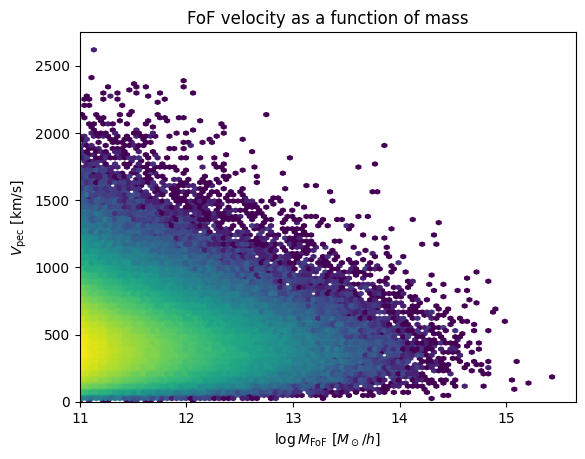

In [9]:
plt.figure()
plt.title("FoF velocity as a function of mass")
plt.hexbin(np.log10(mass), velmag, mincnt=1, bins="log")


plt.xlim(np.log10(np.min(mass)))
plt.ylim(0)
plt.xlabel(r"$\log M_{\rm FoF} ~ [M_\odot / h]$")
plt.ylabel(r"$V_{\rm pec} ~ [\mathrm{km} / \mathrm{s}]$")

plt.savefig("../plots/fof_velocity_to_mass.png", dpi=300, bbox_inches="tight")
plt.show()

### Subfind subhaloes

In [23]:
catalogue = csiborgtools.read.CSiBORG2SUBFINDCatalogue(nsim, nsnap, kind)

mass = catalogue["totmass"]
vec = np.linalg.norm(catalogue["cartesian_vel"], axis=1)
is_central = catalogue["Central"]

def get_binned_trend(x, y, nbins=20):
    median, bin_edges, __ = binned_statistic(x, y, bins=nbins, statistic="median")
    lower, __, __ = binned_statistic(x, y, bins=nbins, statistic=lambda x: np.percentile(x, 16))
    upper, __, __ = binned_statistic(x, y, bins=nbins, statistic=lambda x: np.percentile(x, 84))
    std, __, __ = binned_statistic(x, y, bins=nbins, statistic="std")
    xrange = (bin_edges[1:] + bin_edges[:-1]) / 2
    std = (upper - lower) / 2
    return xrange, median, lower, upper, std

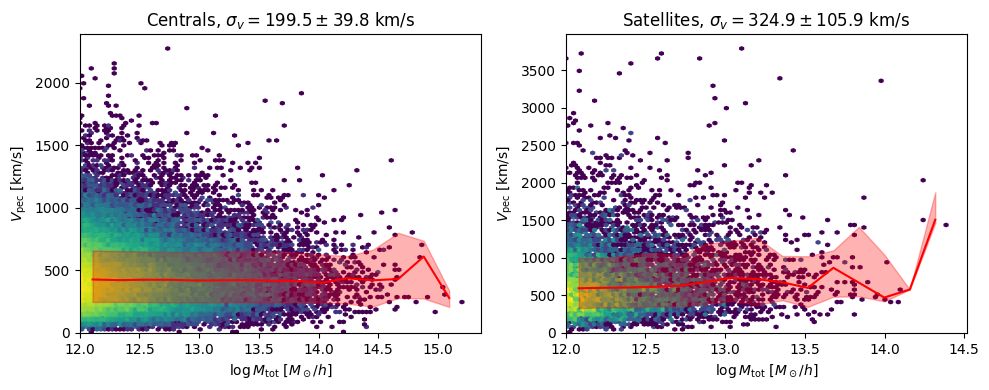

In [25]:
nbins = 15

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Centrals
mask = is_central & (mass > 1e12)
x, y = np.log10(mass[mask]), vec[mask]
xrange, median, lower, upper, std = get_binned_trend(x, y, nbins=nbins)
sigma_v, e_sigma_v = np.mean(std), np.std(std)
axs[0].set_title(r"Centrals, $\sigma_v = {:.1f} \pm {:.1f} ~ \mathrm{{km}} / \mathrm{{s}}$".format(sigma_v, e_sigma_v))
axs[0].hexbin(x, y, mincnt=1, bins="log")

axs[0].plot(xrange, median, color="red")
axs[0].fill_between(xrange, lower, upper, color="red", alpha=0.3)

# Satellites
mask = ~is_central & (mass > 1e12)
x, y = np.log10(mass[mask]), vec[mask]
xrange, median, lower, upper, std = get_binned_trend(x, y, nbins=nbins)
sigma_v, e_sigma_v = np.mean(std), np.std(std)
axs[1].set_title(r"Satellites, $\sigma_v = {:.1f} \pm {:.1f} ~ \mathrm{{km}} / \mathrm{{s}}$".format(sigma_v, e_sigma_v))
axs[1].hexbin(x, y, mincnt=1, bins="log")
axs[1].plot(xrange, median, color="red")
axs[1].fill_between(xrange, lower, upper, color="red", alpha=0.3)

for i in range(2):
    axs[i].set_xlim(np.log10(1e12))
    axs[i].set_ylim(0)
    axs[i].set_xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[i].set_ylabel(r"$V_{\rm pec} ~ [\mathrm{km} / \mathrm{s}]$")

fig.tight_layout()
fig.savefig("../plots/velocity_to_mass_subhaloes.png", dpi=300, bbox_inches="tight")
fig.show()

### SUBFIND haloes but subtracting the velocity of the velocity field

In [27]:
field_reader = csiborgtools.read.CSiBORG2Field(nsim, kind)
catalogue = csiborgtools.read.CSiBORG2SUBFINDCatalogue(nsim, nsnap, kind)
boxsize = csiborgtools.simname2boxsize("csiborg2_main")

mass = catalogue["totmass"]
pos = catalogue["cartesian_pos"] / boxsize
subfind_vel = catalogue["cartesian_vel"]
is_central = catalogue["Central"]

parent_mass = catalogue["ParentMass"]

In [13]:
velocity_field = field_reader.velocity_field("SPH", 1024)

In [19]:
vx, vy, vz = csiborgtools.field.evaluate_cartesian_cic(velocity_field[0], velocity_field[1], velocity_field[2], pos=pos)

residual_vel = np.copy(subfind_vel)
residual_vel[:, 0] -= vx
residual_vel[:, 1] -= vy
residual_vel[:, 2] -= vz

residual_vel_mag = np.linalg.norm(residual_vel, axis=1)

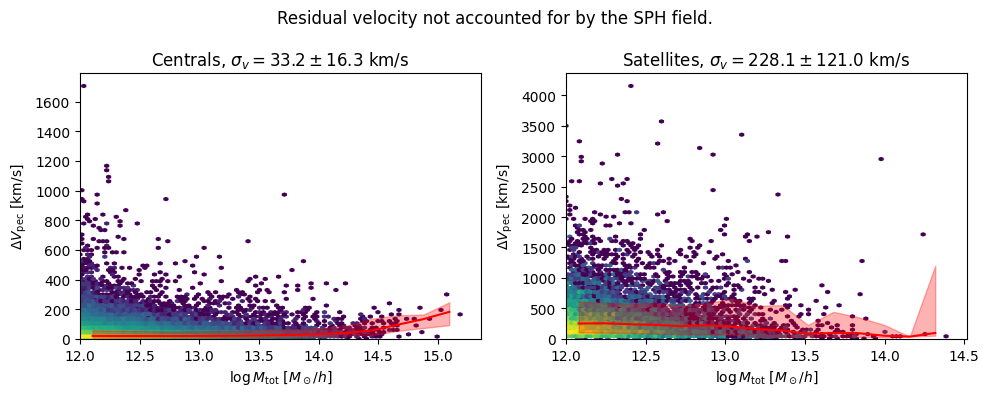

In [26]:
nbins = 15

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Residual velocity not accounted for by the SPH field.")
# Centrals
mask = is_central & (mass > 1e12)
x, y = np.log10(mass[mask]), residual_vel_mag[mask]
xrange, median, lower, upper, std = get_binned_trend(x, y, nbins=nbins)
sigma_v, e_sigma_v = np.mean(std), np.std(std)
axs[0].set_title(r"Centrals, $\sigma_v = {:.1f} \pm {:.1f} ~ \mathrm{{km}} / \mathrm{{s}}$".format(sigma_v, e_sigma_v))
axs[0].hexbin(x, y, mincnt=1, bins="log")

axs[0].plot(xrange, median, color="red")
axs[0].fill_between(xrange, lower, upper, color="red", alpha=0.3)

# Satellites
mask = ~is_central & (mass > 1e12)
x, y = np.log10(mass[mask]), residual_vel_mag[mask]
xrange, median, lower, upper, std = get_binned_trend(x, y, nbins=nbins)
sigma_v, e_sigma_v = np.mean(std), np.std(std)
axs[1].set_title(r"Satellites, $\sigma_v = {:.1f} \pm {:.1f} ~ \mathrm{{km}} / \mathrm{{s}}$".format(sigma_v, e_sigma_v))
axs[1].hexbin(x, y, mincnt=1, bins="log")
axs[1].plot(xrange, median, color="red")
axs[1].fill_between(xrange, lower, upper, color="red", alpha=0.3)

for i in range(2):
    axs[i].set_xlim(np.log10(1e12))
    axs[i].set_ylim(0)
    axs[i].set_xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[i].set_ylabel(r"$\Delta V_{\rm pec} ~ [\mathrm{km} / \mathrm{s}]$")

fig.tight_layout()
fig.savefig("../plots/residual_velocity_to_mass_subhaloes.png", dpi=300, bbox_inches="tight")
fig.show()

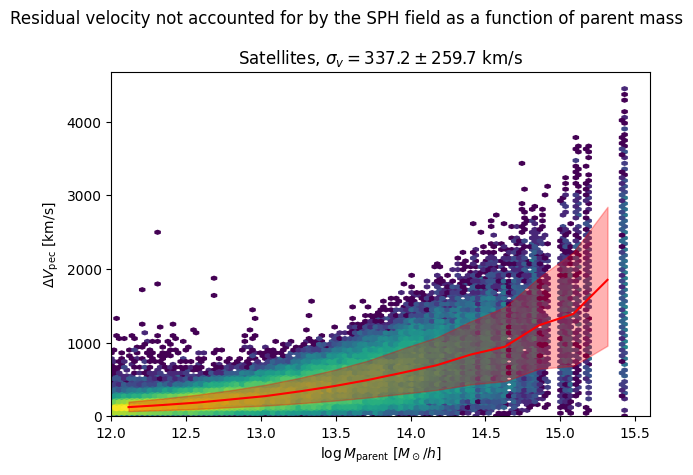

In [34]:
nbins = 15

fig, axs = plt.subplots(1, 1)
axs = [axs]
fig.suptitle("Residual velocity not accounted for by the SPH field as a function of parent mass")

# Satellites
mask = ~is_central & (parent_mass > 1e12)
x, y = np.log10(parent_mass[mask]), residual_vel_mag[mask]
xrange, median, lower, upper, std = get_binned_trend(x, y, nbins=nbins)
sigma_v, e_sigma_v = np.mean(std), np.std(std)
axs[0].set_title(r"Satellites, $\sigma_v = {:.1f} \pm {:.1f} ~ \mathrm{{km}} / \mathrm{{s}}$".format(sigma_v, e_sigma_v))
axs[0].hexbin(x, y, mincnt=1, bins="log")
axs[0].plot(xrange, median, color="red")
axs[0].fill_between(xrange, lower, upper, color="red", alpha=0.3)

axs[0].set_xlim(np.log10(1e12))
axs[0].set_ylim(0)
axs[0].set_xlabel(r"$\log M_{\rm parent} ~ [M_\odot / h]$")
axs[0].set_ylabel(r"$\Delta V_{\rm pec} ~ [\mathrm{km} / \mathrm{s}]$")

fig.tight_layout()
fig.savefig("../plots/residual_velocity_to_mass_subhaloes_parent.png", dpi=300, bbox_inches="tight")
fig.show()